Searching for SLK files: test 2/*.slk
Found files: 160

=== Processing test 2/319J11.slk ===
  mouse_id=319, day=1, trial=1, reversal=False
  N points: 923

=== Processing test 2/319J12.slk ===
  mouse_id=319, day=1, trial=2, reversal=False
  N points: 910

=== Processing test 2/319J13.slk ===
  mouse_id=319, day=1, trial=3, reversal=False
  N points: 910

=== Processing test 2/319J14.slk ===
  mouse_id=319, day=1, trial=4, reversal=False
  N points: 910

=== Processing test 2/319J21.slk ===
  mouse_id=319, day=2, trial=1, reversal=False
  N points: 921

=== Processing test 2/319J22.slk ===
  mouse_id=319, day=2, trial=2, reversal=False
  N points: 911

=== Processing test 2/319J23.slk ===
  mouse_id=319, day=2, trial=3, reversal=False
  N points: 161

=== Processing test 2/319J24.slk ===
  mouse_id=319, day=2, trial=4, reversal=False
  N points: 271

=== Processing test 2/319J31.slk ===
  mouse_id=319, day=3, trial=1, reversal=False
  N points: 360

=== Processing test 2/319J32.slk ==

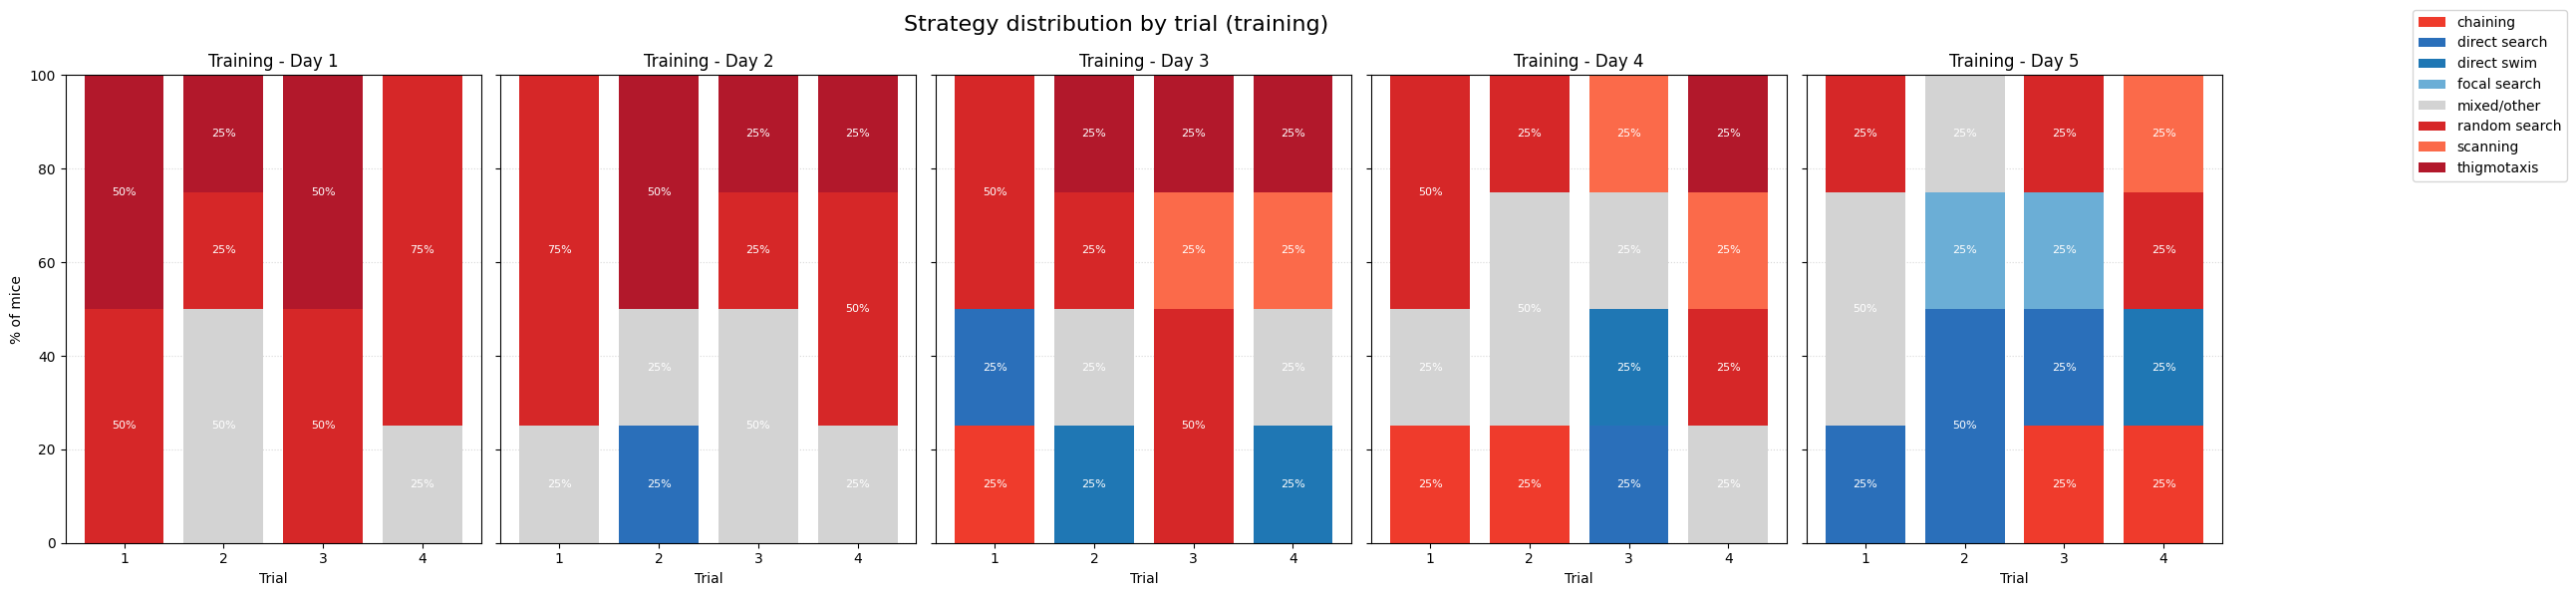

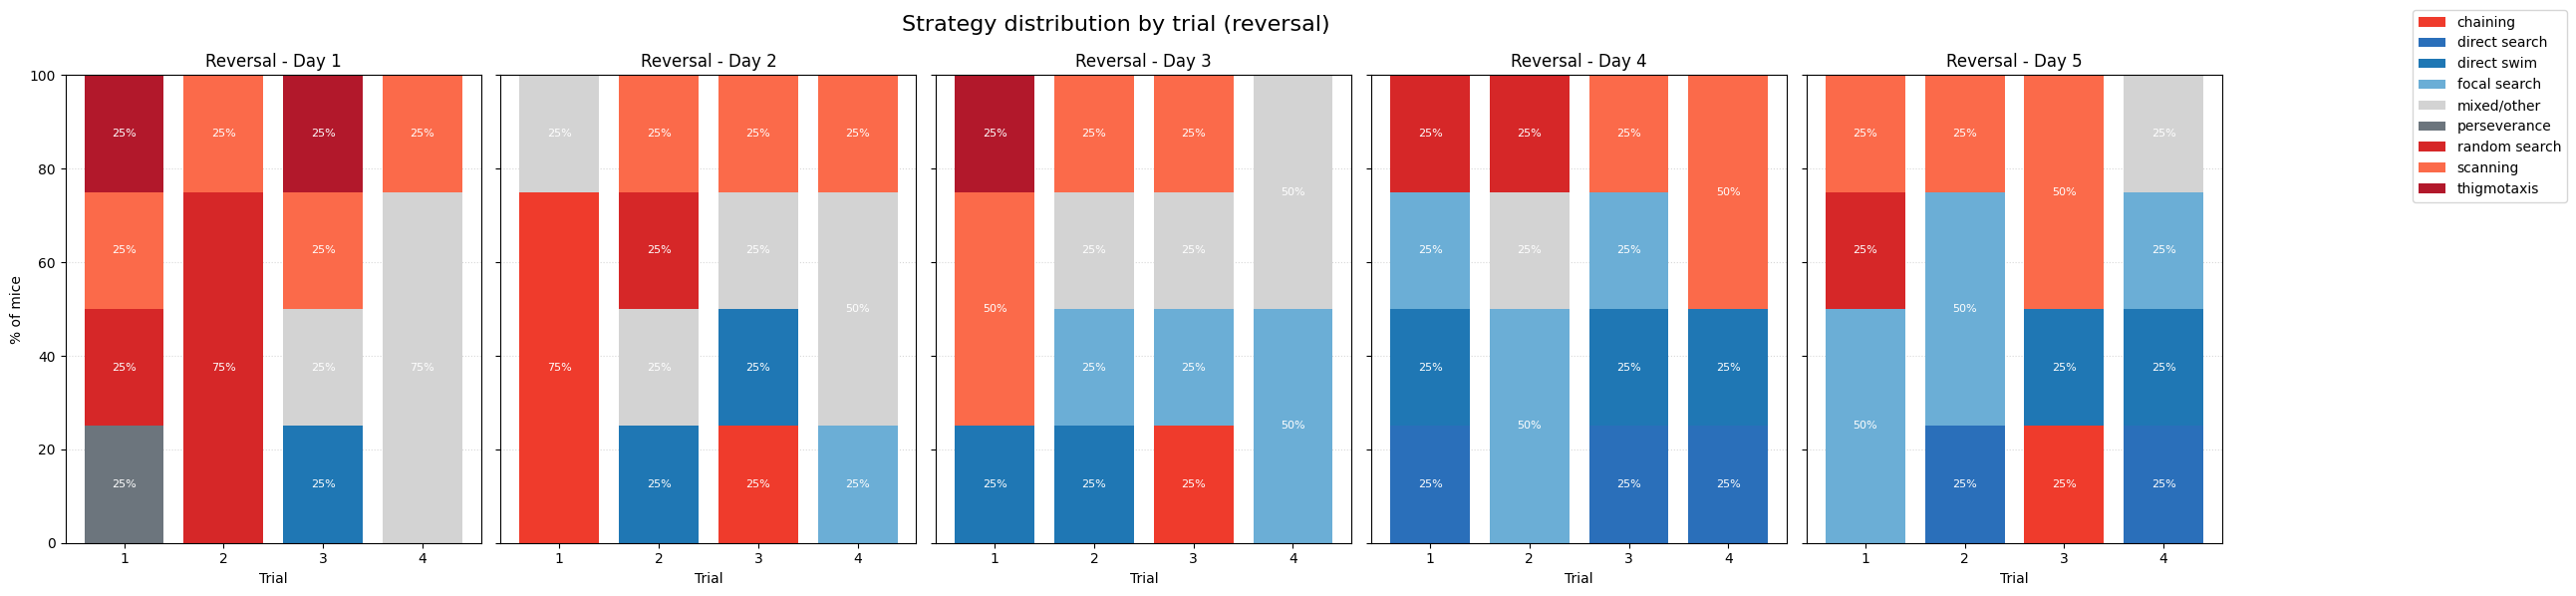

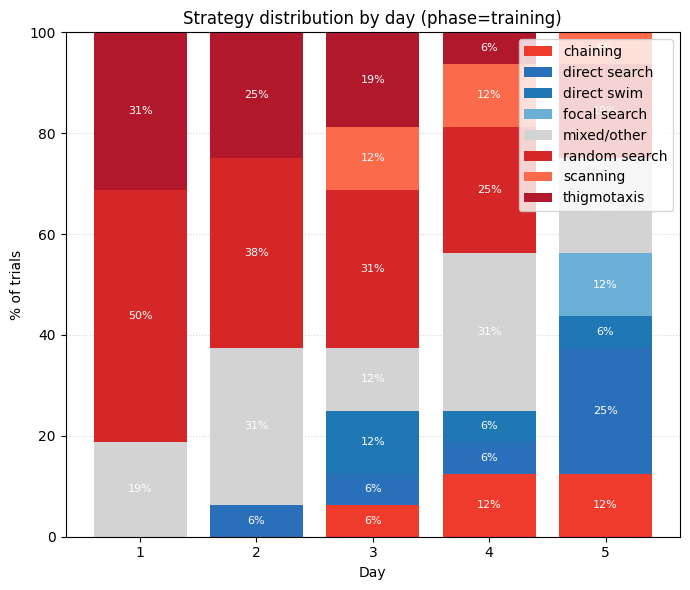

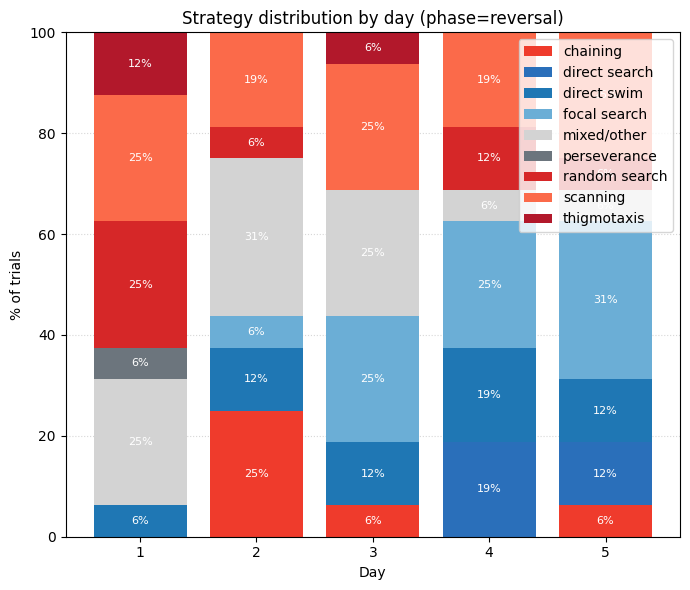

Saved: strategy_pct_by_phase_day_trial.csv


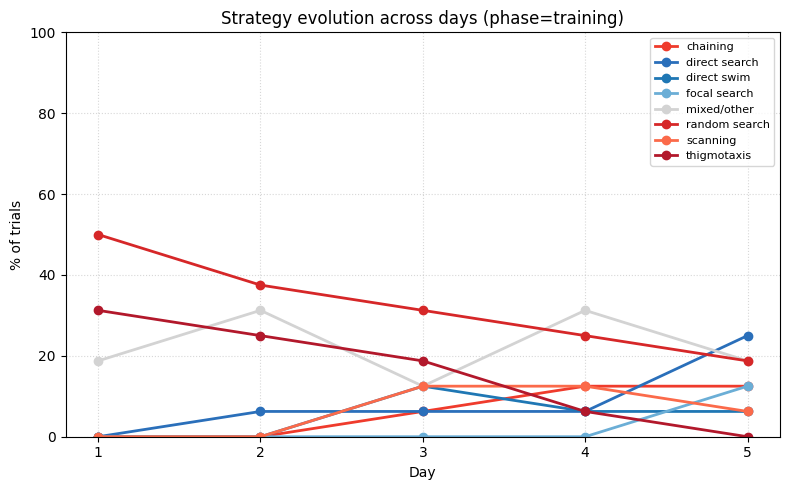

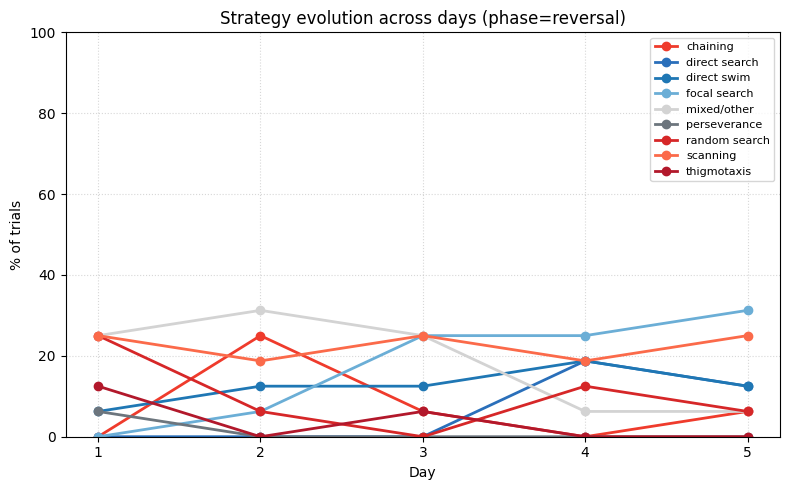

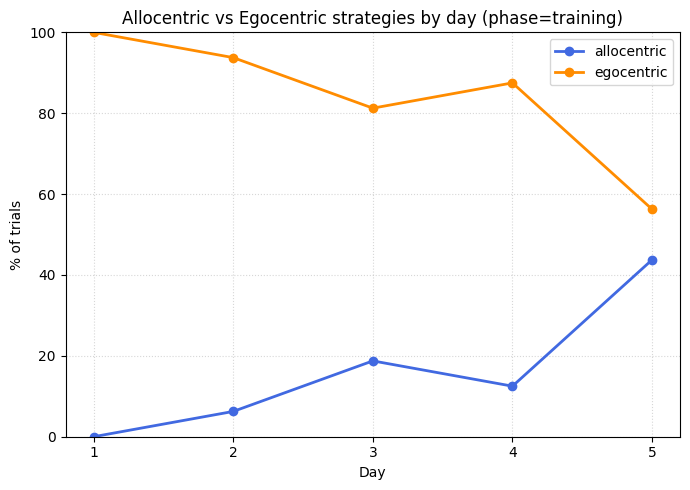

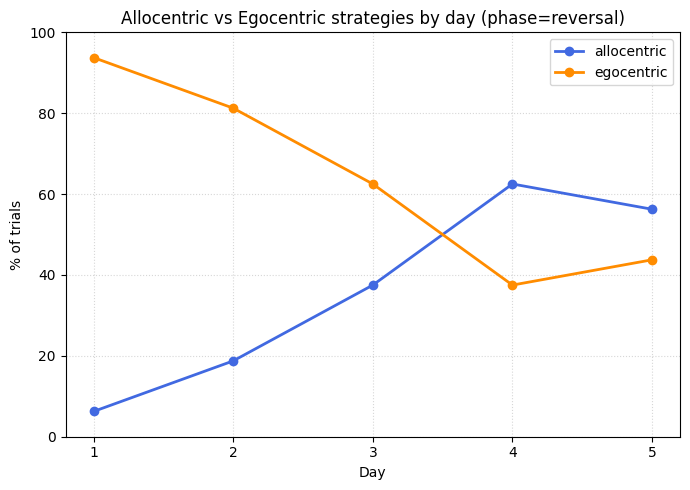

Saved: strategy_per_mouse_by_phase_day_trial.csv
Saved: mixed_candidates_per_mouse_by_phase_day_trial.csv


,mouse_id,day,trial,reversal,strategy,mixed_candidates,phase
0,319,1,1,False,thigmotaxis,None,training
1,319,1,2,False,thigmotaxis,None,training
2,319,1,3,False,thigmotaxis,None,training
3,319,1,4,False,random search,None,training
4,319,2,1,False,random search,None,training
...,...,...,...,...,...,...,...
155,415,4,4,True,scanning,None,reversal
156,415,5,1,True,focal search,None,reversal
157,415,5,2,True,focal search,None,reversal
158,415,5,3,True,chaining,None,reversal


In [1]:
import glob
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Wedge, Circle

# =====================================================================
# TOGGLES + FILE PATTERN
# =====================================================================

PLOT_TRAJECTORIES = False   # True → show individual trajectories
PLOT_POLAR        = False   # True → show polar occupancy
DEBUG_PRINT       = False   # True → print per-file metrics

FILE_GLOB_PATTERN = "test 2/*.slk"

# =====================================================================
# GEOMETRY & CONSTANTS
# =====================================================================

POOL_CX, POOL_CY = 333, 231
POOL_A,  POOL_B  = 453 / 2, 451 / 2  # semi-axes in pixels

RINGS = [
    (333, 231, 453 / 2, 451 / 2),  # Ring 1 (outermost)
    (333, 231, 392 / 2, 392 / 2),  # Ring 2
    (334, 228, 326 / 2, 325 / 2),  # Ring 3
    (336, 229, 268 / 2, 265 / 2),  # Ring 4
    (336, 229, 206 / 2, 204 / 2),  # Ring 5 (innermost)
]

PLATFORM1_X, PLATFORM1_Y = 407, 137   # training
PLATFORM2_X, PLATFORM2_Y = 243, 303   # reversal

POOL_DIAM_CM = 120.0
PIXELS_PER_CM = 453 / POOL_DIAM_CM

# corridor ~ 20 cm
CORRIDOR_WIDTH_CM = 20.0
CORRIDOR_HALF_WIDTH_PX = (CORRIDOR_WIDTH_CM / 2.0) * PIXELS_PER_CM

# platform ellipse
PLAT_WIDTH_PX  = 33.0
PLAT_HEIGHT_PX = 34.0
PLAT_A = PLAT_WIDTH_PX / 2.0
PLAT_B = PLAT_HEIGHT_PX / 2.0

# platform zone = 20x platform area
PLATFORM_ZONE_FACTOR = 20
PLATFORM_ZONE_RADIUS_PX = math.sqrt(PLATFORM_ZONE_FACTOR * PLAT_A * PLAT_B)

# polar bins
POLAR_N_RINGS   = 5
POLAR_N_SECTORS = 12
POLAR_ROT_DEG   = 0.0
POLAR_RADIUS_PIX = min(POOL_A, POOL_B)

# thresholds (easy to tune)
ALLOCENTRIC_THRESHOLD = 0.80            # ≥80% in goal corridor

RANDOM_RING5_THRESHOLD          = 0.60   # fraction in ring 5 threshold used for random/scanning-like
CHAINING_RING3_5_THRESHOLD      = 0.80   # chaining: ≥80% in rings 3–5
THIGMO_RING1_3_THRESHOLD        = 0.80   # thigmotaxis: ≥80% in rings 1–3

# random vs scanning using polar coverage
RANDOM_POLAR_MIN_COVERAGE       = 0.60   # random: polar coverage > 60%
SCANNING_POLAR_MIN_COVERAGE     = 0.10   # scanning: coverage ≥10%
SCANNING_POLAR_MAX_COVERAGE     = 0.60   # scanning: coverage ≤60%
SCANNING_RING45_THRESHOLD       = 0.70   # scanning: ≥70% of points in rings 4–5

SCANNING_MIN_RING_CROSSINGS       = 4    # (still tracked if needed later; not in current rule)
DOMINANCE_EPS = 0.02  # if |tangential_fraction - 0.5| ≤ 0.02 → treat as "equal"

# perseverance: search old platform during reversal
PERSEVERANCE_OLD_PLATFORM_THRESHOLD = 0.30  # ≥30% of samples in old (training) platform zone

# =====================================================================
# SLK LOADER
# =====================================================================

def load_slk(filepath: str) -> pd.DataFrame:
    """Return DataFrame with x,y columns from AnyMaze .slk."""
    frames = {}
    with open(filepath, "r") as f:
        for line in f:
            if not line.startswith("C;"):
                continue
            parts = line.strip().split(";")
            col = row = None
            val = None
            for p in parts[1:]:
                if p.startswith("X"):
                    col = int(p[1:]) if p[1:].isdigit() else None
                elif p.startswith("Y"):
                    row = int(p[1:]) if p[1:].isdigit() else None
                elif p.startswith("K"):
                    v = p[1:]
                    if v.startswith('"') and v.endswith('"'):
                        v = v[1:-1]
                    try:
                        val = float(v)
                    except ValueError:
                        val = None
            if col in (2, 3) and row is not None and val is not None:
                frames.setdefault(row, {})[col] = val

    x_vals, y_vals = [], []
    for row in sorted(frames.keys()):
        frame = frames[row]
        if 2 in frame and 3 in frame:
            x_vals.append(frame[2])
            y_vals.append(frame[3])

    return pd.DataFrame({"x": x_vals, "y": y_vals})

# =====================================================================
# BASIC GEOMETRY HELPERS
# =====================================================================

def in_ellipse(x, y, cx, cy, a, b):
    return ((x - cx) / a) ** 2 + ((y - cy) / b) ** 2 <= 1.0

def point_in_pool(x, y):
    return in_ellipse(x, y, POOL_CX, POOL_CY, POOL_A, POOL_B)

def classify_ring(x, y):
    if not point_in_pool(x, y):
        return None
    inside = [in_ellipse(x, y, cx, cy, a, b) for (cx, cy, a, b) in RINGS]
    for idx in reversed(range(len(inside))):  # inner → outer
        if inside[idx]:
            return idx + 1
    return None

def classify_quadrant(x, y):
    if not point_in_pool(x, y):
        return None
    dx = x - POOL_CX
    dy_math = -(y - POOL_CY)
    angle = math.atan2(dy_math, dx)
    if 0 <= angle < math.pi/2:
        return 1
    if math.pi/2 <= angle <= math.pi:
        return 2
    if -math.pi <= angle < -math.pi/2:
        return 3
    if -math.pi/2 <= angle < 0:
        return 4
    return None

# =====================================================================
# POLAR HELPERS
# =====================================================================

def polar_indices(x, y,
                  n_rings=POLAR_N_RINGS,
                  n_sectors=POLAR_N_SECTORS,
                  rotation_deg=POLAR_ROT_DEG):
    """Return in_pool_mask, ring indices (ri), sector indices (si)."""
    xn = (x - POOL_CX) / POOL_A
    yn = (y - POOL_CY) / POOL_B
    r = np.sqrt(xn**2 + yn**2)
    th = (np.arctan2(yn, xn) + 2.0 * math.pi) % (2.0 * math.pi)

    rot = math.radians(rotation_deg)
    th = (th - rot + 2.0 * math.pi) % (2.0 * math.pi)

    in_pool_mask = r <= 1.0
    ri = np.floor(r * n_rings).astype(int)
    ri = np.clip(ri, 0, n_rings - 1)

    sector_width = 2.0 * math.pi / n_sectors
    si = np.floor(th / sector_width).astype(int)
    si = np.clip(si, 0, n_sectors - 1)

    ri[~in_pool_mask] = -1
    si[~in_pool_mask] = -1
    return in_pool_mask, ri, si

def polar_coverage(ri, si, n_rings, n_sectors):
    """Which polar bins were visited at least once."""
    visited = np.zeros((n_rings, n_sectors), dtype=bool)
    mask = (ri >= 0) & (si >= 0)
    if np.any(mask):
        visited[ri[mask], si[mask]] = True
    hits = int(visited.sum())
    total = int(n_rings * n_sectors)
    frac = hits / total if total else 0.0
    return hits, total, frac, visited

# =====================================================================
# CORRIDOR & PLATFORM ZONE
# =====================================================================

def points_in_goal_corridor(df, corridor_half_width_px, plat_x, plat_y):
    """Boolean mask of samples inside start→platform tube."""
    n = len(df)
    if plat_x is None or plat_y is None or n == 0:
        return np.zeros(n, dtype=bool)

    x0, y0 = df.iloc[0]["x"], df.iloc[0]["y"]
    x1, y1 = plat_x, plat_y

    ABx, ABy = x1 - x0, y1 - y0
    AB2 = ABx**2 + ABy**2
    if AB2 == 0:
        return np.zeros(n, dtype=bool)

    Px = df["x"].to_numpy(float)
    Py = df["y"].to_numpy(float)

    APx = Px - x0
    APy = Py - y0

    t = (APx * ABx + APy * ABy) / AB2
    t = np.clip(t, 0.0, 1.0)

    Cx = x0 + t * ABx
    Cy = y0 + t * ABy

    dist = np.sqrt((Px - Cx)**2 + (Py - Cy)**2)
    return dist <= corridor_half_width_px

def points_in_platform_zone(df, plat_x, plat_y, radius_px=PLATFORM_ZONE_RADIUS_PX):
    """Boolean mask of samples inside circular platform zone."""
    n = len(df)
    if plat_x is None or plat_y is None or n == 0:
        return np.zeros(n, dtype=bool)
    dx = df["x"].to_numpy(float) - plat_x
    dy = df["y"].to_numpy(float) - plat_y
    dist = np.sqrt(dx*dx + dy*dy)
    return dist <= radius_px

# =====================================================================
# EXTRA ANALYTICS
# =====================================================================

def sector_entropy(si, n_sectors):
    """Normalized entropy (0..1) of sector occupancy."""
    valid = si >= 0
    if not np.any(valid):
        return 0.0
    counts = np.bincount(si[valid], minlength=n_sectors).astype(float)
    total = counts.sum()
    if total <= 0:
        return 0.0
    p = counts / total
    p = p[p > 0]
    H  = -(p * np.log2(p)).sum()
    Hm = np.log2(n_sectors) if n_sectors > 1 else 1.0
    return float(H / Hm) if Hm > 0 else 0.0

def count_ring_crossings(ri):
    """Number of ring index changes across consecutive valid samples."""
    valid = ri >= 0
    ri_valid = ri[valid]
    if len(ri_valid) < 2:
        return 0
    return int(np.sum(np.abs(np.diff(ri_valid)) > 0))

def tangential_vs_radial_counts(df):
    """
    Tangential vs radial steps in ellipse-normalized coords.
    Tangential if arc (r_mean * |Δθ|) > |Δr|.
    """
    x = df["x"].to_numpy(float)
    y = df["y"].to_numpy(float)
    xn = (x - POOL_CX) / POOL_A
    yn = (y - POOL_CY) / POOL_B
    r  = np.sqrt(xn*xn + yn*yn)
    if len(r) < 3:
        return 0, 0, 0.0

    th  = np.unwrap(np.arctan2(yn, xn))
    dr  = np.abs(np.diff(r))
    dth = np.abs(np.diff(th))
    r_mean = (r[:-1] + r[1:]) / 2.0
    arc = r_mean * dth

    tang_mask = arc > dr
    tang_steps = int(np.sum(tang_mask))
    radial_steps = int(len(tang_mask) - tang_steps)
    tang_frac = tang_steps / max(len(tang_mask), 1)
    return tang_steps, radial_steps, float(tang_frac)

def path_features_for_random(x, y, ring_seq_raw):
    """Features used to detect 'random search' (central scribble)."""
    dx = np.diff(x)
    dy = np.diff(y)
    step = np.sqrt(dx*dx + dy*dy)
    path_len = float(step.sum())
    displacement = float(math.hypot(x[-1] - x[0], y[-1] - y[0]))
    tortuosity = path_len / max(displacement, 1e-6)

    v1x, v1y = dx[:-1], dy[:-1]
    v2x, v2y = dx[1:],  dy[1:]
    n1 = np.sqrt(v1x*v1x + v1y*v1y)
    n2 = np.sqrt(v2x*v2x + v2y*v2y)
    ok = (n1 > 1e-9) & (n2 > 1e-9)

    cosang = np.zeros_like(v1x, dtype=float)
    cosang[ok] = (v1x[ok]*v2x[ok] + v1y[ok]*v2y[ok]) / (n1[ok]*n2[ok])
    cosang = np.clip(cosang, -1.0, 1.0)
    ang = np.degrees(np.arccos(cosang))
    mean_abs_turn_deg = float(np.nanmean(ang)) if ang.size else 0.0

    rr = pd.Series(ring_seq_raw, dtype="float").fillna(-1).to_numpy()
    r0 = rr[:-1]
    r1 = rr[1:]
    valid = (r0 > 0) & (r1 > 0)
    trans = np.count_nonzero((r0 != r1) & valid)
    pairs = int(valid.sum())
    ring_transition_rate = trans / max(pairs, 1)

    return tortuosity, mean_abs_turn_deg, float(ring_transition_rate)

# =====================================================================
# STRATEGY CLASSIFICATION
# =====================================================================

def classify_strategy(df, plat_x, plat_y, polar_hits, polar_total, polar_frac):
    """
    Allocentric:
      - focal search
      - direct swim
      - direct search
    Non-allocentric:
      - random search
      - thigmotaxis
      - chaining
      - scanning
      - mixed/other
    """
    n = len(df)
    if n == 0:
        return "no_data", {}

    rings = df["ring"].to_numpy()
    in_pool_mask = df["in_pool"].to_numpy()
    valid = in_pool_mask & ~pd.isna(rings)
    if valid.sum() == 0:
        return "outside_pool", {}

    rings_valid = rings[valid].astype(int)
    n_valid = len(rings_valid)

    frac_outer_1_3  = np.isin(rings_valid, [1, 2, 3]).sum() / n_valid
    frac_middle_3_5 = np.isin(rings_valid, [3, 4, 5]).sum() / n_valid
    frac_inner_5    = (rings_valid == 5).sum() / n_valid
    frac_inner_4_5  = np.isin(rings_valid, [4, 5]).sum() / n_valid

    corridor_mask = points_in_goal_corridor(df, CORRIDOR_HALF_WIDTH_PX, plat_x, plat_y)
    frac_corridor = float(corridor_mask.mean())

    metrics = {
        "frac_outer_1_3":  float(frac_outer_1_3),
        "frac_middle_3_5": float(frac_middle_3_5),
        "frac_inner_5":    float(frac_inner_5),
        "frac_inner_4_5":  float(frac_inner_4_5),
        "frac_corridor":   float(frac_corridor),
        "polar_hits":      int(polar_hits),
        "polar_total":     int(polar_total),
        "polar_coverage":  float(polar_frac),
    }

    TH = ALLOCENTRIC_THRESHOLD

    # ---------- 1) Allocentric ----------
    if frac_corridor >= TH and plat_x is not None and plat_y is not None:
        coords = df[["x", "y"]].to_numpy(float)
        platform = np.array([plat_x, plat_y], float)

        if len(coords) > 1:
            diffs = np.diff(coords, axis=0)
            seg_lengths = np.sqrt((diffs**2).sum(axis=1))
            path_length = seg_lengths.sum()
        else:
            path_length = 0.0

        beeline_dist = np.linalg.norm(platform - coords[0])
        straightness_global = beeline_dist / path_length if path_length > 0 else 0.0

        plat_mask = points_in_platform_zone(df, plat_x, plat_y, PLATFORM_ZONE_RADIUS_PX)
        frac_platform_zone = float(plat_mask.mean())

        if plat_mask.sum() >= 2:
            coords_zone = coords[plat_mask]
            diffs_zone = np.diff(coords_zone, axis=0)
            seg_lengths_zone = np.sqrt((diffs_zone**2).sum(axis=1))
            path_length_zone = seg_lengths_zone.sum()
            beeline_zone = np.linalg.norm(platform - coords_zone[0])
            straightness_platform = (
                beeline_zone / path_length_zone if path_length_zone > 0 else 0.0
            )
        else:
            straightness_platform = 1.0

        metrics["straightness_global"] = float(straightness_global)
        metrics["frac_platform_zone"] = float(frac_platform_zone)
        metrics["straightness_platform"] = float(straightness_platform)

        if (frac_platform_zone >= 0.60) and (straightness_platform <= 0.30):
            return "focal search", metrics
        elif straightness_global >= 0.70:
            return "direct swim", metrics
        else:
            return "direct search", metrics

    # ---------- 2) Non-allocentric ----------

    x = df["x"].to_numpy(float)
    y = df["y"].to_numpy(float)

    # polar indices for coverage + ring crossings
    _, ri_pi, si_pi = polar_indices(x, y, POLAR_N_RINGS, POLAR_N_SECTORS, POLAR_ROT_DEG)
    _, _, _, visited = polar_coverage(ri_pi, si_pi, POLAR_N_RINGS, POLAR_N_SECTORS)
    n_cross = count_ring_crossings(ri_pi)

    # tangential vs radial dominance (still used for thigmo / chaining only)
    tang_steps, radial_steps, tang_frac = tangential_vs_radial_counts(df)

    if abs(tang_frac - 0.5) <= DOMINANCE_EPS:
        majority = "equal"
    else:
        majority = "tangential" if tang_frac > 0.5 else "radial"

    # ---- default label ----
    label = "mixed/other"

    # 2a) RANDOM vs SCANNING (same priority, purely polar-based)

    # Random search:
    #   - polar coverage > 60%
    if float(polar_frac) > RANDOM_POLAR_MIN_COVERAGE:
        label = "random search"

    # Scanning:
    #   - polar coverage between 10% and 60%
    #   - AND ≥70% of points in rings 4–5 (inner zone)
    elif (SCANNING_POLAR_MIN_COVERAGE <= float(polar_frac) <= SCANNING_POLAR_MAX_COVERAGE and
          frac_inner_4_5 >= SCANNING_RING45_THRESHOLD):
        label = "scanning"

    else:
        # 2b) If neither random nor scanning, use majority + simple ring rules
        if majority == "tangential":
            # Chaining: middle rings (3–5)
            if frac_middle_3_5 >= CHAINING_RING3_5_THRESHOLD:
                label = "chaining"
            # Thigmotaxis: mostly outer rings (1–3)
            elif frac_outer_1_3 >= THIGMO_RING1_3_THRESHOLD:
                label = "thigmotaxis"

        elif majority == "radial":
            # no dedicated radial-only strategy here
            pass

    # 2c) If still mixed/other, store "closest" strategy types
    if label == "mixed/other":
        candidates = []
        if float(polar_frac) > 0.40:
            candidates.append("random-like")
        if (SCANNING_POLAR_MIN_COVERAGE <= float(polar_frac) <= SCANNING_POLAR_MAX_COVERAGE and
            frac_inner_4_5 >= 0.40):
            candidates.append("scanning-like")
        if frac_middle_3_5 >= 0.50:
            candidates.append("chaining-like")
        if frac_outer_1_3 >= 0.50:
            candidates.append("thigmo-like")
        metrics["mixed_candidates"] = candidates

    metrics.update({
        "ring_crossings":      int(n_cross),
        "tangential_steps":    int(tang_steps),
        "radial_steps":        int(len(df) - tangential_vs_radial_counts(df)[0]),
        "tangential_fraction": float(tang_frac),
        "dominance":           majority,
        "dominance_margin":    float(abs(tang_frac - 0.5)),
    })
    return label, metrics

# =====================================================================
# PLOTTING: SINGLE-TRIAL
# =====================================================================

def plot_classic(ax, df, plat_x, plat_y, title):
    for i, (cx, cy, a, b) in enumerate(RINGS, start=1):
        e = Ellipse((cx, cy), 2*a, 2*b, fill=False, linewidth=1, alpha=0.6)
        ax.add_patch(e)
        ax.text(cx + a + 5, cy, f"R{i}", fontsize=7, va="center")

    ax.axvline(POOL_CX, linestyle="--", linewidth=1, alpha=0.7)
    ax.axhline(POOL_CY, linestyle="--", linewidth=1, alpha=0.7)

    ax.plot(df["x"], df["y"], linewidth=1)

    if plat_x is not None and plat_y is not None:
        ax.scatter([plat_x], [plat_y], marker="x")
        ax.text(plat_x + 5, plat_y, "Platform", fontsize=7)
        circle = Circle((plat_x, plat_y), PLATFORM_ZONE_RADIUS_PX,
                        fill=False, linestyle=":", linewidth=1, alpha=0.5)
        ax.add_patch(circle)

    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.set_title(title)
    margin = 50
    ax.set_xlim(POOL_CX - POOL_A - margin, POOL_CX + POOL_A + margin)
    ax.set_ylim(POOL_CY + POOL_B + margin, POOL_CY - POOL_B - margin)

def plot_polar(ax, visited, df, title, rotation_deg=POLAR_ROT_DEG):
    ax.add_patch(Circle((POOL_CX, POOL_CY), POLAR_RADIUS_PIX, fill=False, linewidth=2))
    n_rings, n_sectors = visited.shape
    r_edges = np.linspace(0.0, POLAR_RADIUS_PIX, n_rings + 1)
    sector_width = 360.0 / n_sectors
    rot = rotation_deg

    for ri in range(n_rings):
        r0, r1 = r_edges[ri], r_edges[ri + 1]
        for si in range(n_sectors):
            theta1 = rot + si * sector_width
            theta2 = theta1 + sector_width
            if visited[ri, si]:
                ax.add_patch(Wedge((POOL_CX, POOL_CY), r1, theta1, theta2,
                                   width=(r1 - r0), alpha=0.15))
            ax.add_patch(Wedge((POOL_CX, POOL_CY), r1, theta1, theta2,
                               width=(r1 - r0), fill=False, linewidth=0.6))

    ax.plot(df["x"], df["y"], linewidth=1)
    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.set_title(title)
    margin = 50
    ax.set_xlim(POOL_CX - POOL_A - margin, POOL_CX + POOL_A + margin)
    ax.set_ylim(POOL_CY + POOL_B + margin, POOL_CY - POOL_B - margin)

# =====================================================================
# UPDATED PLOTTING FUNCTIONS (better colors, spacing, perseverance = grey)
# =====================================================================

# bright, scientific-style palette
STRATEGY_COLORS = {
    # --- Allocentric (BLUE SHADES) ---
    "direct swim":   "#1f77b4",  # Medium blue
    "direct search": "#2a6fba",  # Deeper blue
    "focal search":  "#6baed6",  # Light blue

    # --- Egocentric (RED SHADES) ---
    "random search": "#d62728",  # Strong red
    "thigmotaxis":   "#b2182b",  # Dark red
    "chaining":      "#ef3b2c",  # Medium red
    "scanning":      "#fb6a4a",  # Light red/coral

    # --- Neutral ---
    "perseverance":  "#6C757D",  # Grey
    "mixed/other":   "#D3D3D3",  # Light grey
}


def get_color(strat):
    return STRATEGY_COLORS.get(strat, "#cccccc")

# Which strategies are considered allocentric
ALLOCENTRIC_STRATEGIES = {
    "direct swim",
    "direct search",
    "focal search",
}

def plot_strategy_by_trial(summary_df, phase_label):
    df = summary_df[summary_df["phase"] == phase_label].copy()
    if df.empty:
        print(f"No data for phase '{phase_label}'")
        return

    days = sorted(df["day"].dropna().unique())
    strategies = sorted(df["strategy"].dropna().unique())

    fig, axes = plt.subplots(
        1, len(days),
        figsize=(4.5 * len(days), 6),  # taller plots
        sharey=True
    )

    if len(days) == 1:
        axes = [axes]

    for ax, day in zip(axes, days):
        sub = df[df["day"] == day]

        totals = sub.groupby("trial")["mouse_id"].nunique()
        counts = (
            sub.groupby(["trial", "strategy"])["mouse_id"]
            .nunique()
            .reset_index(name="n_mice")
        )

        table = counts.pivot(index="trial", columns="strategy",
                             values="n_mice").fillna(0)

        for trial in table.index:
            total = totals.get(trial, 0)
            table.loc[trial] = table.loc[trial] / total * 100.0 if total > 0 else 0.0

        table = table.reindex(columns=strategies, fill_value=0.0).sort_index()
        x = np.arange(len(table.index))
        bottom = np.zeros(len(table))

        for strat in strategies:
            vals = table[strat].values
            bars = ax.bar(
                x, vals,
                bottom=bottom,
                color=get_color(strat),
                label=strat
            )

            for i, bar in enumerate(bars):
                v = vals[i]
                if v > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bottom[i] + v / 2,
                        f"{v:.0f}%",
                        ha="center", va="center",
                        fontsize=8, color="white"
                    )
            bottom += vals

        ax.set_xticks(x)
        ax.set_xticklabels(table.index.astype(int))
        ax.set_xlabel("Trial")
        ax.set_title(f"{phase_label.capitalize()} - Day {int(day)}")

        ax.set_ylim(0, 100)
        ax.yaxis.grid(True, linestyle=":", alpha=0.5)
        ax.set_axisbelow(True)

        if ax is axes[0]:
            ax.set_ylabel("% of mice")

    # spacing between figures
    plt.subplots_adjust(wspace=0.3)

    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1.0))
    fig.suptitle(f"Strategy distribution by trial ({phase_label})", fontsize=16)
    plt.tight_layout()
    plt.show()



def plot_strategy_by_day(summary_df, phase_label):
    df = summary_df[summary_df["phase"] == phase_label].copy()
    if df.empty:
        print(f"No data for phase '{phase_label}'")
        return

    df = df.dropna(subset=["day", "strategy"])

    counts = (
        df.groupby(["day", "strategy"])
        .size()
        .reset_index(name="n_trials")
    )
    totals = df.groupby("day").size()

    table = counts.pivot(index="day", columns="strategy",
                         values="n_trials").fillna(0)

    for day in table.index:
        table.loc[day] = (
            table.loc[day] / totals.loc[day] * 100
            if totals.loc[day] > 0 else 0.0
        )

    days = sorted(table.index)
    strategies = list(table.columns)

    table = table.reindex(index=days, columns=strategies).fillna(0.0)

    fig, ax = plt.subplots(figsize=(7, 6))  # taller

    x = np.arange(len(days))
    bottom = np.zeros(len(days))

    for strat in strategies:
        vals = table[strat].values
        bars = ax.bar(
            x, vals,
            bottom=bottom,
            color=get_color(strat),
            label=strat
        )
        for i, bar in enumerate(bars):
            v = vals[i]
            if v > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bottom[i] + v/2,
                    f"{v:.0f}%",
                    ha="center", va="center",
                    fontsize=8, color="white"
                )
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels([int(d) for d in days])
    ax.set_xlabel("Day")
    ax.set_ylabel("% of trials")
    ax.set_title(f"Strategy distribution by day (phase={phase_label})")

    ax.set_ylim(0, 100)
    ax.yaxis.grid(True, linestyle=":", alpha=0.5)
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def plot_strategy_lines_by_day(summary_df, phase_label):
    """
    Line plot: evolution of each strategy across *days* for a given phase
    ('training' or 'reversal').

    Uses summary_df where each row is a trial with a 'strategy'.
    We compute % of trials per day that use each strategy.
    """
    df = summary_df[summary_df["phase"] == phase_label].copy()
    if df.empty:
        print(f"No data for phase '{phase_label}' in strategy-by-day lines")
        return

    df = df.dropna(subset=["day", "strategy"])

    # how many trials per (day, strategy)
    counts = (
        df.groupby(["day", "strategy"])
        .size()
        .reset_index(name="n_trials")
    )

    # total number of trials per day
    totals = (
        df.groupby("day")
        .size()
        .rename("n_total")
        .reset_index()
    )

    merged = counts.merge(totals, on="day", how="left")
    merged["pct"] = merged["n_trials"] / merged["n_total"] * 100.0

    # pivot: rows = day, columns = strategy, values = % of trials
    table = merged.pivot(index="day", columns="strategy", values="pct").fillna(0.0)

    days = sorted(table.index)
    strategies = list(table.columns)

    fig, ax = plt.subplots(figsize=(8, 5))

    for strat in strategies:
        vals = table[strat].loc[days].values
        ax.plot(
            days,
            vals,
            marker="o",
            linewidth=2,
            label=strat,
            color=get_color(strat),
        )

    ax.set_xticks(days)
    ax.set_xticklabels([int(d) for d in days])
    ax.set_xlabel("Day")
    ax.set_ylabel("% of trials")
    ax.set_title(f"Strategy evolution across days (phase={phase_label})")
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_alloc_vs_egoc_by_day(summary_df, phase_label):
    """
    Two curves: allocentric vs egocentric strategies across days,
    for a given phase ('training' or 'reversal').
    """
    df = summary_df[summary_df["phase"] == phase_label].copy()
    if df.empty:
        print(f"No data for phase '{phase_label}' in alloc/egoc plot")
        return

    # classify each trial as allocentric vs egocentric
    df["class"] = np.where(df["strategy"].isin(ALLOCENTRIC_STRATEGIES),
                           "allocentric", "egocentric")

    # count trials per (day, class)
    counts = (
        df.groupby(["day", "class"])
        .size()
        .reset_index(name="n_trials")
    )

    # total trials per day
    totals = df.groupby("day").size().rename("n_total").reset_index()

    merged = counts.merge(totals, on="day", how="left")
    merged["pct"] = merged["n_trials"] / merged["n_total"] * 100.0

    # pivot to day x class
    table = merged.pivot(index="day", columns="class", values="pct").fillna(0.0)
    days = sorted(table.index)

    fig, ax = plt.subplots(figsize=(7, 5))

    # ensure both columns exist
    for cls, col_color in zip(
        ["allocentric", "egocentric"],
        ["#4169E1", "#FF8C00"],  # blue, orange
    ):
        if cls in table.columns:
            ax.plot(
                days,
                table[cls].values,
                marker="o",
                linewidth=2,
                label=cls,
                color=col_color,
            )

    ax.set_xticks(days)
    ax.set_xticklabels([int(d) for d in days])
    ax.set_xlabel("Day")
    ax.set_ylabel("% of trials")
    ax.set_title(f"Allocentric vs Egocentric strategies by day (phase={phase_label})")
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()


# =====================================================================
# FILENAME PARSING
# =====================================================================

def parse_filename(base_name: str):
    """
    Parse mouse_id, day, trial, is_reversal from a filename like:
      '321J2.slk' or '321J2reversal3.slk'
    """
    name_lower = base_name.lower()
    try:
        mouse_id = int(base_name[:3])
    except Exception:
        mouse_id = None

    try:
        j_index = name_lower.index("j")
        day = int(base_name[j_index + 1])
    except Exception:
        day = None

    is_reversal = "reversal" in name_lower

    trial = None
    try:
        if is_reversal:
            rev_index = name_lower.rfind("reversal")
            trial_str = base_name[rev_index + len("reversal"):]
            if trial_str:
                trial = int(trial_str)
        else:
            trial = int(base_name[j_index + 2])
    except Exception:
        trial = None

    return mouse_id, day, trial, is_reversal

# =====================================================================
# MAIN
# =====================================================================

print(f"Searching for SLK files: {FILE_GLOB_PATTERN}")
files = sorted(glob.glob(FILE_GLOB_PATTERN))
print("Found files:", len(files))

summaries = []

for path in files:
    print("\n=== Processing", path, "===")
    base = os.path.splitext(os.path.basename(path))[0]
    mouse_id, day, trial, is_reversal = parse_filename(base)
    print(f"  mouse_id={mouse_id}, day={day}, trial={trial}, reversal={is_reversal}")

    plat_x, plat_y = (PLATFORM2_X, PLATFORM2_Y) if is_reversal else (PLATFORM1_X, PLATFORM1_Y)

    df = load_slk(path)
    print("  N points:", len(df))
    if df.empty:
        print("  (empty, skipping)")
        continue

    # annotate regions
    df["in_pool"] = df.apply(lambda r: point_in_pool(r["x"], r["y"]), axis=1)
    df["ring"]     = df.apply(lambda r: classify_ring(r["x"], r["y"]), axis=1)
    df["quadrant"] = df.apply(lambda r: classify_quadrant(r["x"], r["y"]), axis=1)

    # polar coverage
    x = df["x"].to_numpy(float)
    y = df["y"].to_numpy(float)
    in_pool_mask, ri, si = polar_indices(x, y, POLAR_N_RINGS, POLAR_N_SECTORS, POLAR_ROT_DEG)
    hits, total, frac_cov, visited = polar_coverage(ri, si, POLAR_N_RINGS, POLAR_N_SECTORS)

    # classify strategy (standard rules)
    strategy, metrics = classify_strategy(df, plat_x, plat_y, hits, total, frac_cov)
    strategy_before_persev = strategy  # keep a copy

    # --- PERSEVERANCE: during REVERSAL, search in OLD platform location (platform 1) ---
    old_plat_mask = points_in_platform_zone(df, PLATFORM1_X, PLATFORM1_Y, PLATFORM_ZONE_RADIUS_PX)
    frac_old_platform_zone = float(old_plat_mask.mean())
    metrics["frac_old_platform_zone"] = frac_old_platform_zone  # always store

    if is_reversal and frac_old_platform_zone >= PERSEVERANCE_OLD_PLATFORM_THRESHOLD:
        strategy = "perseverance"

    if DEBUG_PRINT:
        print(f"  Base strategy: {strategy_before_persev}")
        print(f"  is_reversal={is_reversal}, "
              f"frac_old_platform_zone={frac_old_platform_zone:.3f}, "
              f"final strategy={strategy}")
        interesting = [
            "frac_corridor", "frac_platform_zone", "straightness_global",
            "straightness_platform", "frac_outer_1_3", "frac_middle_3_5",
            "frac_inner_5", "polar_coverage",
            "frac_old_platform_zone",
            "mixed_candidates",
        ]
        print("  Metrics:", {k: metrics.get(k) for k in interesting if k in metrics})

    if PLOT_TRAJECTORIES:
        fig, ax = plt.subplots(figsize=(5, 5))
        title1 = f"{base} (mouse={mouse_id}, day={day}, trial={trial}, rev={is_reversal})\nStrategy: {strategy}"
        plot_classic(ax, df, plat_x, plat_y, title1)
        plt.tight_layout()
        plt.show()

    if PLOT_POLAR:
        fig, ax = plt.subplots(figsize=(5, 5))
        title2 = f"{base}  polar coverage: {frac_cov*100:.1f}% ({hits}/{total})"
        plot_polar(ax, visited, df, title2, rotation_deg=POLAR_ROT_DEG)
        plt.tight_layout()
        plt.show()

    # SAVE mixed_candidates inside the summary
    summaries.append({
        "mouse_id": mouse_id,
        "day": day,
        "trial": trial,
        "reversal": is_reversal,
        "strategy": strategy,
        "mixed_candidates": metrics.get("mixed_candidates"),
    })

# =====================================================================
# SUMMARY DATAFRAMES + EXPORT
# =====================================================================

summary_df = pd.DataFrame(summaries)
summary_df = summary_df.dropna(subset=["mouse_id", "day", "trial", "strategy"])
summary_df[["mouse_id", "day", "trial"]] = summary_df[["mouse_id", "day", "trial"]].astype(int)
summary_df["phase"] = np.where(summary_df["reversal"], "reversal", "training")

# plots
plot_strategy_by_trial(summary_df, "training")
plot_strategy_by_trial(summary_df, "reversal")
plot_strategy_by_day(summary_df, "training")
plot_strategy_by_day(summary_df, "reversal")

# table 1: (phase, day, trial) x strategy → % of mice
counts_dt = (
    summary_df.groupby(["phase", "day", "trial", "strategy"])["mouse_id"]
    .nunique()
    .reset_index(name="n_mice")
)
totals_dt = (
    summary_df.groupby(["phase", "day", "trial"])["mouse_id"]
    .nunique()
    .rename("n_mice_total")
    .reset_index()
)
merged_dt = counts_dt.merge(totals_dt, on=["phase", "day", "trial"], how="left")
merged_dt["pct_mice"] = merged_dt["n_mice"] / merged_dt["n_mice_total"] * 100.0
strategy_pct_by_day_trial = (
    merged_dt.pivot_table(
        index=["phase", "day", "trial"],
        columns="strategy",
        values="pct_mice",
        fill_value=0.0,
    )
    .sort_index()
)
strategy_pct_by_day_trial.to_csv("strategy_pct_by_phase_day_trial.csv")
print("Saved: strategy_pct_by_phase_day_trial.csv")

# NEW: line plots per day, one curve per strategy
plot_strategy_lines_by_day(summary_df, "training")
plot_strategy_lines_by_day(summary_df, "reversal")

# 🔹 NEW allocentric vs egocentric plots by day
plot_alloc_vs_egoc_by_day(summary_df, "training")
plot_alloc_vs_egoc_by_day(summary_df, "reversal")

# table 2: (phase, day, trial) x mouse_id → strategy
strategy_per_mouse = (
    summary_df
    .pivot_table(
        index=["phase", "day", "trial"],
        columns="mouse_id",
        values="strategy",
        aggfunc="first"
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
)
strategy_per_mouse.to_csv("strategy_per_mouse_by_phase_day_trial.csv")
print("Saved: strategy_per_mouse_by_phase_day_trial.csv")

# ---- NEW: table 3: mixed candidates per mouse ----
mixed_candidates_per_mouse = (
    summary_df
    .pivot_table(
        index=["phase", "day", "trial"],
        columns="mouse_id",
        values="mixed_candidates",
        aggfunc="first"
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
)

mixed_candidates_per_mouse.to_csv("mixed_candidates_per_mouse_by_phase_day_trial.csv")
print("Saved: mixed_candidates_per_mouse_by_phase_day_trial.csv")


summary_df

In [ ]:
# =====================================================================
# 🔎 Minimal search bar → BOTH plots (classic rings + polar) with Next/Reset
# =====================================================================

# --- Display helper: show immediately (Jupyter or normal window), never save ---
def _display_figure(fig):
    try:
        from IPython.display import display
        display(fig)
        plt.close(fig)
        return
    except Exception:
        pass
    try:
        plt.show()
    finally:
        plt.close(fig)

# --- One renderer that makes BOTH plots for a single file ---
def show_both_for_path(path, base):
    df = load_slk(path)
    if df.empty:
        raise RuntimeError(f"Empty file: {path}")

    # annotate minimal fields used by classifier
    df["in_pool"] = df.apply(lambda r: point_in_pool(r["x"], r["y"]), axis=1)
    df["ring"]     = df.apply(lambda r: classify_ring(r["x"], r["y"]), axis=1)

    # polar bins
    x = df["x"].to_numpy(float); y = df["y"].to_numpy(float)
    _, ri, si = polar_indices(x, y, POLAR_N_RINGS, POLAR_N_SECTORS, POLAR_ROT_DEG)
    hits, total, frac_cov, visited = polar_coverage(ri, si, POLAR_N_RINGS, POLAR_N_SECTORS)

    # choose platform from filename
    _, _, _, is_rev = parse_filename(base)
    plat_x, plat_y = (PLATFORM2_X, PLATFORM2_Y) if is_rev else (PLATFORM1_X, PLATFORM1_Y)

    # classify + perseverance override (reversal)
    strategy, _metrics = classify_strategy(df, plat_x, plat_y, hits, total, frac_cov)
    if is_rev:
        old_plat_mask = points_in_platform_zone(df, PLATFORM1_X, PLATFORM1_Y, PLATFORM_ZONE_RADIUS_PX)
        if float(old_plat_mask.mean()) >= PERSEVERANCE_OLD_PLATFORM_THRESHOLD:
            strategy = "perseverance"

    # --- Figure 1: classic rings + trajectory + platform
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    title1 = f"{base} — {strategy} (classic rings)"
    plot_classic(ax1, df, plat_x, plat_y, title1)
    plt.tight_layout()
    _display_figure(fig1)

    # --- Figure 2: polar bins + trajectory
    fig2, ax2 = plt.subplots(figsize=(5, 5))
    title2 = f"{base} — {strategy} — polar coverage: {frac_cov*100:.1f}% ({hits}/{total})"
    plot_polar(ax2, visited, df, title2, rotation_deg=POLAR_ROT_DEG)
    plt.tight_layout()
    _display_figure(fig2)

# --- Build a tiny index from your existing 'files' list (fallbacks if needed) ---
try:
    _all_files = list(files)
except NameError:
    _all_files = []
if not _all_files:
    _all_files = glob.glob("*.slk") + glob.glob("**/*.slk", recursive=True)
    try:
        _all_files += glob.glob(FILE_GLOB_PATTERN)
    except Exception:
        pass
_all_files = sorted(set(_all_files))
_index_records = [{"base": os.path.splitext(os.path.basename(p))[0], "path": p} for p in _all_files]
_index_df = pd.DataFrame(_index_records)

# --- Search helpers (exact → startswith → contains) ---
def _find_by_base(index_df: pd.DataFrame, user_text: str):
    if index_df is None or index_df.empty or not user_text:
        return None, None, []
    df = index_df.copy()
    df["__lower"] = df["base"].astype(str).str.lower()
    q = os.path.splitext(user_text)[0].strip().lower()

    exact = df[df["__lower"] == q]
    if len(exact) == 1:
        r = exact.iloc[0]; return r["path"], r["base"], [r["base"]]
    if len(exact) > 1:
        return None, None, exact["base"].tolist()

    starts = df[df["__lower"].str.startswith(q)]
    if len(starts) == 1:
        r = starts.iloc[0]; return r["path"], r["base"], [r["base"]]
    if len(starts) > 1:
        return None, None, starts["base"].tolist()

    contains = df[df["__lower"].str.contains(q)]
    if len(contains) == 1:
        r = contains.iloc[0]; return r["path"], r["base"], [r["base"]]
    return None, None, contains["base"].tolist()

# --- Tiny Tk search bar with Go / Next / Reset (CLI fallback loops) ---
try:
    import tkinter as tk
    from tkinter import ttk, messagebox
    _TK_OK = True
except Exception:
    _TK_OK = False

def launch_search_bar_both_plots(index_df: pd.DataFrame, on_render=None, title="MWM Search (rings + polar)"):
    if index_df is None or index_df.empty:
        print("No files indexed for search bar."); return
    if on_render is None:
        on_render = show_both_for_path

    # prepare a list to cycle with Next ▶
    bases_list = sorted(index_df["base"].astype(str).unique().tolist())
    if not bases_list:
        print("No base names available."); return

    # Try to start Tk; fall back if not available
    root = None
    if _TK_OK:
        try:
            root = tk.Tk()
        except Exception:
            root = None

    if root is None:
        # CLI fallback: loop so you can query multiple files
        print(f"\n[{len(index_df)} files indexed] Enter base names (blank to quit).")
        while True:
            q = input("Base name: ").strip()
            if not q:
                break
            path, base, hits = _find_by_base(index_df, q)
            if path:
                try:
                    on_render(path, base)
                except Exception as e:
                    print("Error:", e)
            else:
                if not hits:
                    print(f"No match for '{q}'.")
                else:
                    print("Multiple matches:", ", ".join(sorted(set(hits))[:20]))
                    print("Please be more specific.")
        return

    # --- GUI layout ---
    root.title(title)
    tk.Label(root, text="File name (no extension):").grid(row=0, column=0, padx=6, pady=8, sticky="e")
    v_query = tk.StringVar()
    entry = ttk.Entry(root, textvariable=v_query, width=40)
    entry.grid(row=0, column=1, padx=6, pady=8, sticky="w")

    info = tk.StringVar(value=f"{len(index_df)} files indexed.")
    tk.Label(root, textvariable=info, foreground="#555").grid(row=1, column=0, columnspan=3, padx=6, sticky="w")

    idx = tk.IntVar(value=0)  # cycling index for Next ▶

    def on_go():
        q = v_query.get().strip()
        path, base, hits = _find_by_base(index_df, q)
        if path:
            try:
                on_render(path, base)
                info.set(f"Shown: {base}")
            except Exception as e:
                messagebox.showerror("Error", str(e))
        else:
            if not hits:
                messagebox.showwarning("Not found", f"No match for: '{q}'.")
            else:
                preview = ", ".join(sorted(set(hits))[:12])
                messagebox.showinfo("Ambiguous", f"Multiple matches:\n{preview}\n\nPlease be more specific.")

    def on_next():
        # cycle through the list and auto-render
        if not bases_list:
            return
        i = idx.get() % len(bases_list)
        base = bases_list[i]
        v_query.set(base)
        idx.set((i + 1) % len(bases_list))
        on_go()
        entry.selection_range(0, tk.END)
        entry.icursor(tk.END)
        entry.focus_set()

    def on_reset():
        v_query.set("")
        info.set(f"{len(index_df)} files indexed.")
        entry.focus_set()

    # Buttons
    ttk.Button(root, text="Go", command=on_go).grid(row=0, column=2, padx=6, pady=8)
    ttk.Button(root, text="Next ▶", command=on_next).grid(row=0, column=3, padx=4, pady=8)
    ttk.Button(root, text="Reset", command=on_reset).grid(row=0, column=4, padx=4, pady=8)

    entry.bind("<Return>", lambda e: on_go())
    entry.focus_set()
    root.mainloop()

# --- Launch it ---
launch_search_bar_both_plots(_index_df, on_render=show_both_for_path)


[160 files indexed] Enter base names (blank to quit).


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=02ffb3a7-f1f8-4631-b7f7-44afdef896f1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>